In [1]:
# https://keras.io/examples/vision/grad_cam/#setup
# https://dmitry.ai/t/topic/50/2
# Check Lambda Cloud

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

from keras import backend as K
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import pandas as pd
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import decode_predictions
import numpy as np
import seaborn as sns
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

import warnings 
warnings.filterwarnings('ignore')

2024-10-21 12:08:35.703583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 12:08:35.714182: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 12:08:35.717420: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 12:08:35.726423: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-21 12:08:36.566725: W tensorflow/compiler/tf2

In [3]:
# img_path = r'images_dl/pic.png'
img_path = r'images_dl/aiimg02.png'

In [4]:
# Load model 
model = load_model('vgg16_01.h5')

I0000 00:00:1729505318.194595   52569 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729505318.233254   52569 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729505318.233469   52569 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729505318.234653   52569 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

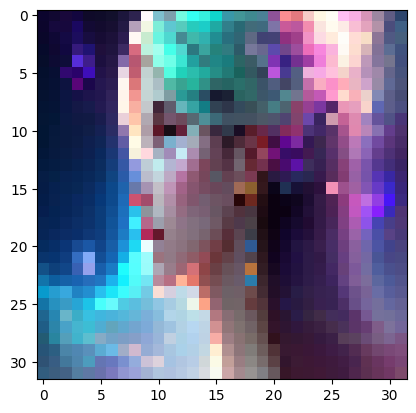

In [5]:
# Load img
img = image.load_img(img_path, target_size=(100, 100))
plt.imshow(img)

In [6]:
img = image.img_to_array(img)
img = preprocess_input(img, data_format=None)
img = img/255.0

img = np.expand_dims(img, axis=0)
img.shape, type(img)

((1, 32, 32, 3), numpy.ndarray)

In [7]:
img_pred = model.predict(img)

I0000 00:00:1729505319.103239   52639 service.cc:146] XLA service 0x77489000b710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729505319.103260   52639 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-10-21 12:08:39.109817: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-21 12:08:39.171740: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-21 12:08:39.580527: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 153.62MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-21 12:08:39.647056: W external/local_tsl/tsl/framework/bfc_allocator.cc:2

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1729505320.142273   52639 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [8]:
print((img_pred > 0.5).astype(int))
# print('FAKE') if (img_pred > 0.5).astype(int) == 0 else 'REAL'
print('FAKE') if img_pred.argmax() == 0 else 'REAL'


[[1]]
FAKE


In [9]:
img.shape

(1, 32, 32, 3)

In [10]:
# CAM

In [11]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]


    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    print(class_channel, 'Grads', grads)
    # # This is a vector where each entry is the mean intensity of the gradient
    # # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

W0000 00:00:1729505320.249117   52569 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729505320.261036   52569 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729505320.262039   52569 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729505320.263024   52569 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729505320.263993   52569 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729505320.264989   52569 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729505320.265964   52569 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729505320.267357   52569 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729505320.274027   52569 gp

tf.Tensor([0.9942979], shape=(1,), dtype=float32) Grads tf.Tensor(
[[[[ 0.0000000e+00 -9.0951391e-05  0.0000000e+00 ...  0.0000000e+00
     0.0000000e+00  4.6198061e-03]
   [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
     0.0000000e+00  0.0000000e+00]]

  [[-3.9643588e-04  0.0000000e+00 -2.3650576e-04 ...  0.0000000e+00
    -9.8636013e-04  0.0000000e+00]
   [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  8.1842998e-04
     0.0000000e+00  0.0000000e+00]]]], shape=(1, 2, 2, 512), dtype=float32)


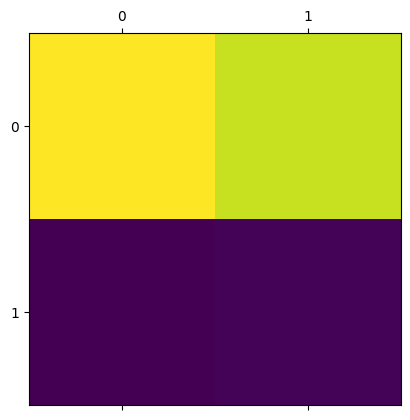

In [12]:
last_conv_layer_name = "block5_conv3"

heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

plt.matshow(heatmap)
plt.show()

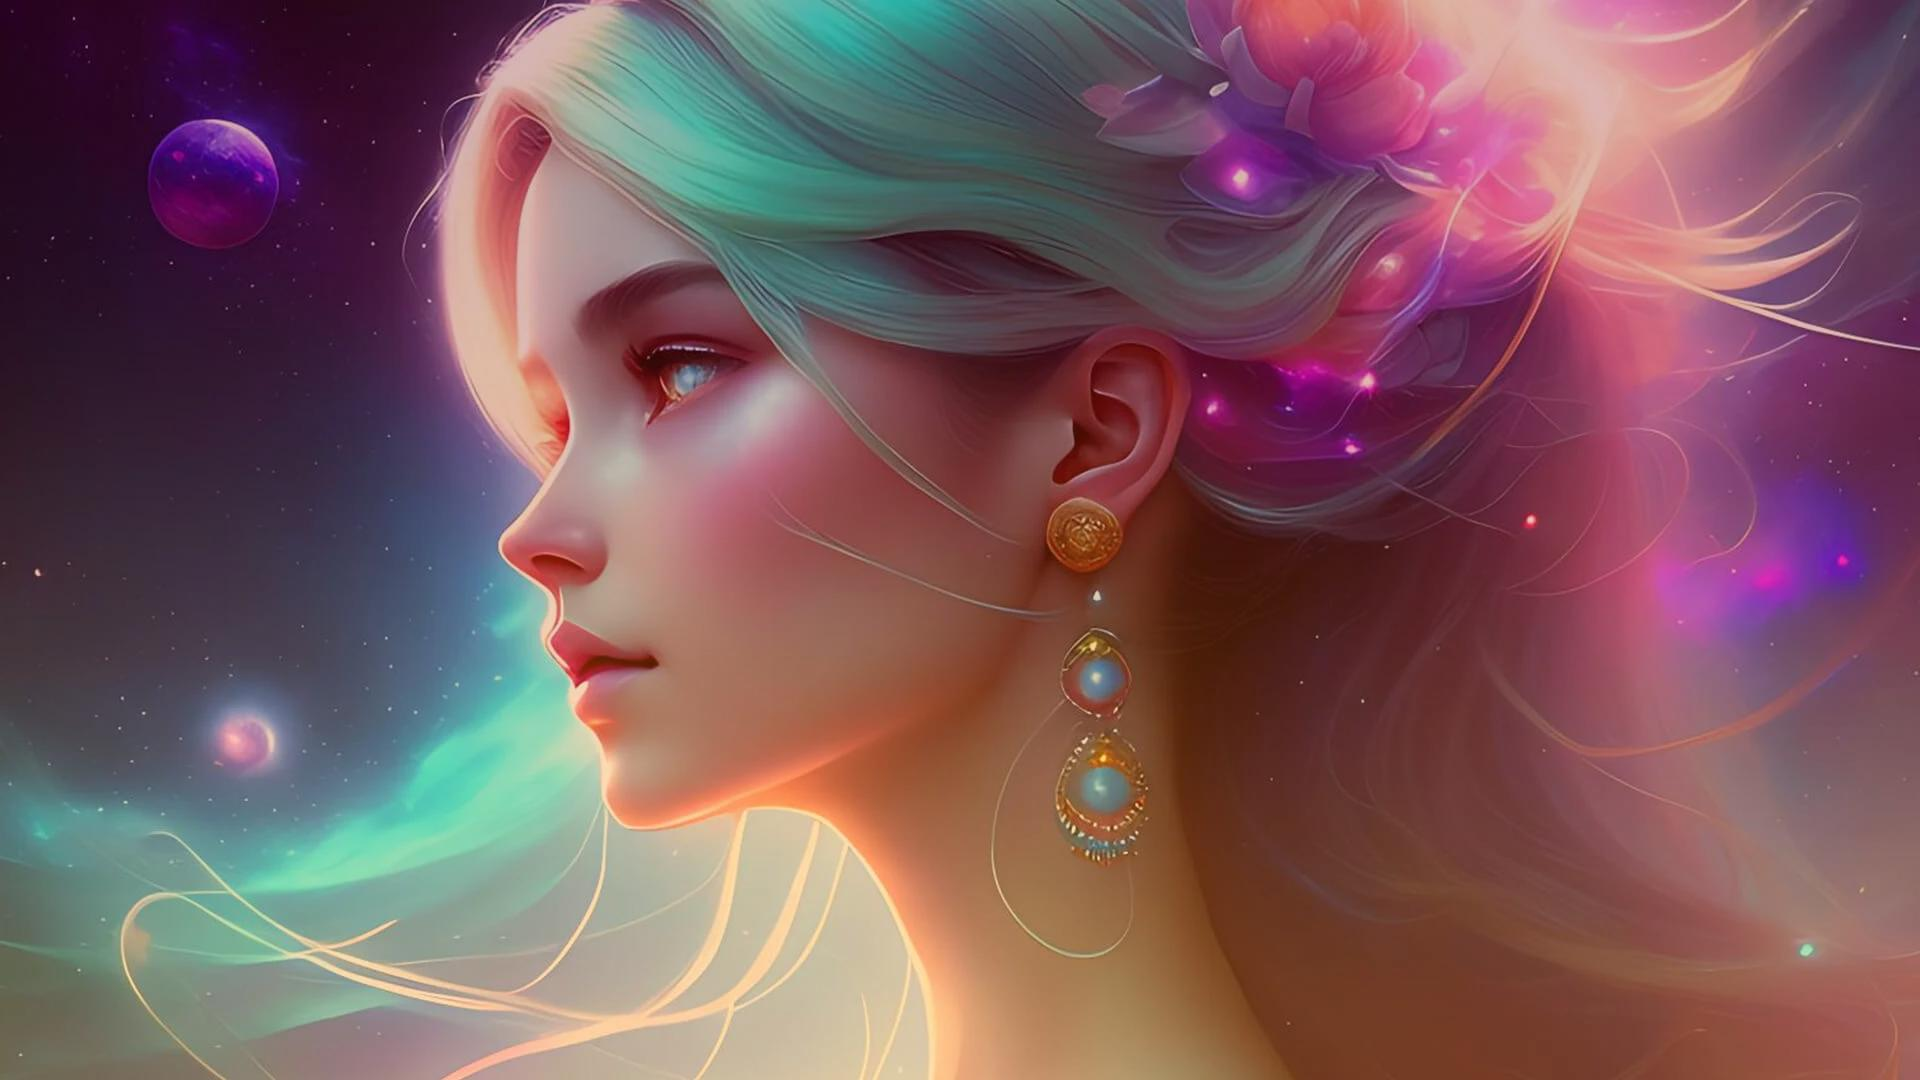

In [13]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)